In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pgzip as gz
import _pickle as pkl
import gc

import pandas as pd

In [2]:
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Conv2D, MaxPool1D, Flatten

## X1: Seq, X2: Gene, Y: Peak

In [3]:
with gz.open('TR_DATA/data_X1.pkl.gz') as f:
    NP_seq = pkl.load(f)

In [4]:
with gz.open('TR_DATA/data_X2_enc.pkl.gz') as f:
    NP_gene = pkl.load(f)

In [5]:
with gz.open('TR_DATA/data_Ys.pkl.gz') as f:
    NP_peak = pkl.load(f)

In [6]:
TR_X1_SEQ = NP_seq.astype('float32')
TR_X2_GENE = NP_gene.astype('float32')
TR_Y_PEAK = NP_peak.astype('float32')

TR_Y_ZERO = (TR_Y_PEAK < 0.1).astype('float32')

TR_Y_W0_0 = 1/(TR_Y_ZERO.mean(axis=0, keepdims=True) + 0.01) + 0.01
TR_Y_W1_0 = 1/(TR_Y_ZERO.mean(axis=1, keepdims=True) + 0.01) + 0.01
TR_Y_W0_1 = 1/(1-1/TR_Y_W0_0)
TR_Y_W1_1 = 1/(1-1/TR_Y_W1_0)

## Make model 

In [7]:
def set_random_seed(name):

    import hashlib
    seed_sha = int(hashlib.sha256(model_id.encode('utf-8')).hexdigest(), 16) % 1000000

    np.random.seed(seed_sha)
    tf.random.set_seed(seed_sha+1)

In [8]:
model_id = 'model_scmnt_1211'
set_random_seed(model_id)

In [9]:
batch_size = 1024
epochs = 200
learning_rate = 3e-3

In [10]:
size_latent = 10
size_gene_input = TR_X2_GENE.shape[1]
size_output = 1#TR_Y_PEAK.shape[2]

In [11]:
class DenseLayers(tf.keras.layers.Layer):
    def __init__(self, layer_params):
        super(DenseLayers, self).__init__()
        
        L_layer = list()
   
        for x in layer_params:
            if x<1:
                l1 = Dropout(rate=x)
            else:
                l1 = Dense( x, activation=tf.nn.relu, kernel_initializer='GlorotNormal')
            L_layer.append( l1 )

        self.hidden_layer = L_layer

    def call(self, input_features):
        x = input_features
        for l1 in self.hidden_layer:
            x = l1(x)
        return x

In [12]:
class ConvLayers(tf.keras.layers.Layer):
    def __init__(self, layer_params):
        super(ConvLayers, self).__init__()
        
        L_layer = list()
   
        for x in layer_params:
            if len(x)==2:
                n_kern, s_kern = x
                l1  = Conv1D( n_kern, s_kern, activation='relu', kernel_initializer='GlorotNormal')
            else:
                n_pool = x[0]
                l1 = MaxPool1D( n_pool )

            L_layer.append( l1 )

        self.hidden_layer = L_layer

    def call(self, input_features):
        x = input_features
        for l1 in self.hidden_layer:
            x = l1(x)
        return x

In [13]:
def act_relu1(x):
    r = tf.minimum(tf.maximum(x, 0), 1)
    return r

In [14]:
class zScoreLayer(tf.keras.layers.Layer):
    def call(self, a):
        σ = tf.math.reduce_std (a, axis=0, keepdims=True)
        μ = tf.math.reduce_mean(a, axis=0, keepdims=True)
        return (a-μ)/σ

In [15]:
class SeqEncoder(tf.keras.layers.Layer):
    def __init__(self):
        super(SeqEncoder, self).__init__()

        layer_params_conv = [(256, 11),    (128,  1),    [99],
                             (128,  1),    [10] ]
        
        self.conv_layers = ConvLayers(layer_params_conv)
        self.flatten_layer = Flatten()

        layer_params_dense = [ 0.1, 256, 0.1 ]

        self.dense_layers = DenseLayers(layer_params_dense)
        self.output_layer = Dense( size_latent, activation=act_relu1, kernel_initializer='GlorotNormal' )
        
    def call(self, input_features):
        x = self.conv_layers(input_features)
        x = self.flatten_layer(x)
        x = self.dense_layers(x)
        return self.output_layer(x)

In [16]:
class GeneEnc2(tf.keras.layers.Layer):
    def __init__(self):
        super(GeneEnc2, self).__init__()

        layer_params = [0.4, 32,
                        0.1]
         
        self.hidden_layer = DenseLayers(layer_params)
        self.output_layer = Dense( size_latent, activation=tf.nn.sigmoid, kernel_initializer='GlorotNormal' )
        self.normal_layer = zScoreLayer()
        
    def call(self, input_features):
        x = self.hidden_layer(input_features)
        x = self.output_layer(x)
        return self.normal_layer(x)

In [17]:
class GeneDec2(tf.keras.layers.Layer):
    def __init__(self):
        super(GeneDec2, self).__init__()

        layer_params = [64, 64]
        
        self.hidden_layer = DenseLayers(layer_params)
        self.output_layer = Dense( size_gene_input, activation=tf.nn.sigmoid, kernel_initializer='GlorotNormal' )
        self.normal_layer = zScoreLayer()
        
    def call(self, input_features):
        x = self.hidden_layer(input_features)
        x = self.output_layer(x)
        return self.normal_layer(x)

In [18]:
class dotLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(dotLayer, self).__init__()
        self.conv2d = Conv2D(1, 1, activation=act_relu1, kernel_initializer='GlorotNormal' )
        self.weight_mask = tf.Variable( tf.random.uniform( (1, size_latent, size_output) ), trainable=True)
        
    def call(self, a, b):
        # a = peaks x latent
        # b = cells x latent
        
        bw = tf.multiply( self.weight_mask, tf.expand_dims(b, 2) )
        c = tf.tensordot( a, bw, axes=[[1],[1]])
        c_dimex = tf.expand_dims(c, -1)
        c_conv = self.conv2d(c_dimex)
        #print(c_conv.shape)
        c_sq = tf.squeeze(c_conv, 2)
        #print(c_sq.shape)
        return c_sq

In [19]:
class MergeingModel(tf.keras.Model):
    def __init__(self):
        super(MergeingModel, self).__init__()
        self.seq_enc = SeqEncoder()
        self.gene_enc = GeneEnc2()
        self.dotlayer = dotLayer()
        #self.gene_dec = GeneDec2()

    def call(self, seq_batch, gene_batch):
        seq_encoded  = self.seq_enc(seq_batch)
        gene_encoded = self.gene_enc(gene_batch)
        pred_peak    = self.dotlayer(seq_encoded, gene_encoded)
        return pred_peak
    
    @tf.function
    def gene_encoded(self, gene_batch):
        encoded = self.gene_enc(gene_batch)
        return encoded
    
    #def gene_decoded(self, gene_batch):
    #    encoded = self.gene_enc(gene_batch)
    #    decoded = self.gene_dec(gene_batch)
    #    return decoded

In [20]:
def loss_seq(model, dataset, data_x2, w0_01 ):
    
    x, y, w1_0, w1_1 = dataset
    w0_0, w0_1 = w0_01
    y_bar = model(x, data_x2)
    #print( y_bar.shape )

    zeros = tf.cast(y<0.1, tf.float32)
    weight0 = (w1_0 + w0_0) * zeros
    weight1 = (w1_1 + w0_1) * (1-zeros)

    sse0 = tf.math.reduce_mean( tf.math.square(y_bar)   * weight0 )
    sse1 = tf.math.reduce_mean( tf.math.square(y_bar-y) * weight1 )
    
    return sse0, sse1

#def loss_ae(model, data_x2 ):
#    
#    y_bar = model.gene_decoded(data_x2)
#    
#    sse_ae = tf.math.reduce_mean( tf.math.square(y_bar - data_x2) )
#    
#    return sse_ae

def loss(model, dataset, data_x2, w0_01 ):
    l0, l1 = loss_seq(model, dataset, data_x2, w0_01 )
    #l2 = loss_ae(model, data_x2 )
    return (l0 + l1)/2   #return l1*0.9+l2*0.1

def train(loss, model, opt, dataset, data_x2, w0_01 ):
    with tf.GradientTape() as tape:
        gradients = tape.gradient( loss( model, dataset, data_x2, w0_01 ), model.trainable_variables)
    gradient_variables = zip(gradients, model.trainable_variables)
    opt.apply_gradients(gradient_variables)

## Make batch and train class0

In [21]:
TF_X1 = tf.data.Dataset.from_tensor_slices(TR_X1_SEQ)
TF_X2 = tf.constant(TR_X2_GENE)

In [22]:
TF_Y  = tf.data.Dataset.from_tensor_slices(TR_Y_PEAK[:,:,0:1])
TF_W1_0 = tf.data.Dataset.from_tensor_slices(TR_Y_W1_0[:,:,0:1])
TF_W1_1 = tf.data.Dataset.from_tensor_slices(TR_Y_W1_1[:,:,0:1])
TR_Y_W0_01 = ( TR_Y_W0_0[:,:,0:1], TR_Y_W0_1[:,:,0:1])

training_dataset = tf.data.Dataset.zip( (TF_X1, TF_Y, TF_W1_0, TF_W1_1) )
training_dataset = training_dataset.batch( batch_size )
training_dataset = training_dataset.shuffle( TR_X1_SEQ.shape[0] )
training_dataset = training_dataset.prefetch( batch_size * 4 )

In [23]:
merged_model = MergeingModel()
l_loss = list()
opt = tf.optimizers.Adamax(learning_rate=learning_rate)

In [24]:
starting_epoch = len(l_loss)
for epoch in range(starting_epoch, epochs):
       
    epoch_loss = list()
    for step, batch_features in enumerate(training_dataset):
        train( loss, merged_model, opt, batch_features, TF_X2, TR_Y_W0_01 )
        loss_values = loss_seq( merged_model, batch_features, TF_X2, TR_Y_W0_01 )
 
        epoch_loss.append( loss_values )
    
    if epoch==0:
        epoch0_loss = epoch_loss

    loss_s01 = np.mean( np.array( epoch_loss ), axis=0 )
    l_loss.append( loss_s01 ) #np.float( loss_ae(merged_model, TF_X2)), ) )
    print('Epoch %d/%d' %(epoch, epochs), loss_s01)

Epoch 0/200 [0.34843823 0.9283065 ]
Epoch 1/200 [0.38175625 0.81176156]
Epoch 2/200 [0.38128248 0.81144977]
Epoch 3/200 [0.39002743 0.78546286]
Epoch 4/200 [0.39091656 0.7820335 ]
Epoch 5/200 [0.39076898 0.78177035]
Epoch 6/200 [0.3905737 0.7819163]
Epoch 7/200 [0.39433178 0.7682504 ]
Epoch 8/200 [0.44621703 0.59590524]
Epoch 9/200 [0.48432082 0.50211394]
Epoch 10/200 [0.48307872 0.5026222 ]
Epoch 11/200 [0.48211727 0.5028112 ]
Epoch 12/200 [0.48190418 0.50236386]
Epoch 13/200 [0.48152202 0.50255895]
Epoch 14/200 [0.48126787 0.50243354]
Epoch 15/200 [0.48128173 0.5020772 ]
Epoch 16/200 [0.48083103 0.5019922 ]
Epoch 17/200 [0.48080394 0.502146  ]
Epoch 18/200 [0.4804543 0.5021717]
Epoch 19/200 [0.48046818 0.5017767 ]
Epoch 20/200 [0.48049393 0.5016004 ]
Epoch 21/200 [0.47994348 0.50182265]
Epoch 22/200 [0.48031628 0.5011412 ]
Epoch 23/200 [0.47980136 0.50145364]
Epoch 24/200 [0.4799049 0.5011481]
Epoch 25/200 [0.479678 0.501109]
Epoch 26/200 [0.479717   0.50101745]
Epoch 27/200 [0.47979

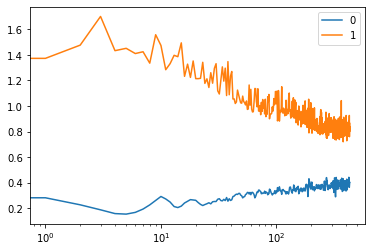

In [25]:
pd.DataFrame(np.array(epoch0_loss)).plot(logx=True)

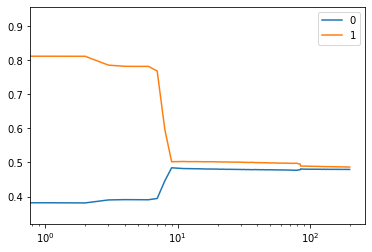

In [26]:
pd.DataFrame(np.array(l_loss)).plot(logx=True)

In [27]:
with gz.open('OUTPUT/loss_c0.pkl.gz', 'wb') as f:
    pkl.dump((epoch0_loss, l_loss), f)

In [28]:
gene_encoded10 = np.array(merged_model.gene_enc(TR_X2_GENE))

In [29]:
with gz.open('OUTPUT/gene_c0_enc.pkl.gz', 'wb') as f:
    pkl.dump(gene_encoded10, f)

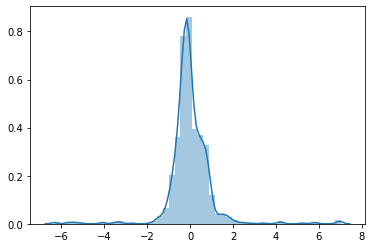

In [30]:
sns.distplot(gene_encoded10.flatten())

In [31]:
total_len = len(TR_X1_SEQ)
L_pred = list()

for x_id in range(0, total_len, 1000):
    TR_1 = TR_X1_SEQ[x_id:x_id+1000]

    pred = merged_model(TR_1, TR_X2_GENE)
    NP_pred = np.array(pred, dtype=np.float16)
    
    L_pred.append(NP_pred)

NP_imputed = np.concatenate(L_pred)
del L_pred
gc.collect()

3641

In [32]:
NP_imputed.shape

(882970, 102, 1)

In [33]:
NP_Nucl = NP_imputed[:,:,0]
pd.DataFrame(NP_Nucl).to_csv('OUTPUT/pred_c0_score_nucl.tsv', sep='\t', header=None, index=None)

In [34]:
Y_Nucl = TR_Y_PEAK[:,:,0]
pd.DataFrame(Y_Nucl).to_csv('OUTPUT/peak_c0_nucl.tsv', sep='\t', header=None, index=None)

## Make batch and train class1

In [35]:
TF_X1 = tf.data.Dataset.from_tensor_slices(TR_X1_SEQ)
TF_X2 = tf.constant(TR_X2_GENE)

In [36]:
TF_Y  = tf.data.Dataset.from_tensor_slices(TR_Y_PEAK[:,:,1:2])
TF_W1_0 = tf.data.Dataset.from_tensor_slices(TR_Y_W1_0[:,:,1:2])
TF_W1_1 = tf.data.Dataset.from_tensor_slices(TR_Y_W1_1[:,:,1:2])
TR_Y_W0_01 = ( TR_Y_W0_0[:,:,1:2], TR_Y_W0_1[:,:,1:2])

training_dataset = tf.data.Dataset.zip( (TF_X1, TF_Y, TF_W1_0, TF_W1_1) )
training_dataset = training_dataset.batch( batch_size )
training_dataset = training_dataset.shuffle( TR_X1_SEQ.shape[0] )
training_dataset = training_dataset.prefetch( batch_size * 4 )

In [37]:
merged_model = MergeingModel()
l_loss = list()
opt = tf.optimizers.Adamax(learning_rate=learning_rate)

In [38]:
starting_epoch = len(l_loss)
for epoch in range(starting_epoch, epochs):
       
    epoch_loss = list()
    for step, batch_features in enumerate(training_dataset):
        train( loss, merged_model, opt, batch_features, TF_X2, TR_Y_W0_01 )
        loss_values = loss_seq( merged_model, batch_features, TF_X2, TR_Y_W0_01 )
 
        epoch_loss.append( loss_values )
    
    if epoch==0:
        epoch0_loss = epoch_loss

    loss_s01 = np.mean( np.array( epoch_loss ), axis=0 )
    l_loss.append( loss_s01 ) #np.float( loss_ae(merged_model, TF_X2)), ) )
    print('Epoch %d/%d' %(epoch, epochs), loss_s01)

Epoch 0/200 [0.37101337 0.8683885 ]
Epoch 1/200 [0.44048634 0.66591465]
Epoch 2/200 [0.44036314 0.66572297]
Epoch 3/200 [0.44018787 0.6658829 ]
Epoch 4/200 [0.4408691 0.6651104]
Epoch 5/200 [0.4404286 0.6654605]
Epoch 6/200 [0.4406034  0.66530013]
Epoch 7/200 [0.44059843 0.66528744]
Epoch 8/200 [0.44071102 0.66517425]
Epoch 9/200 [0.44051874 0.6654003 ]
Epoch 10/200 [0.44065186 0.66522723]
Epoch 11/200 [0.44083634 0.6650565 ]
Epoch 12/200 [0.44058183 0.6652378 ]
Epoch 13/200 [0.44066834 0.6651497 ]
Epoch 14/200 [0.44033292 0.66549826]
Epoch 15/200 [0.44101888 0.66477585]
Epoch 16/200 [0.44034517 0.6654372 ]
Epoch 17/200 [0.44116634 0.6646421 ]
Epoch 18/200 [0.44070905 0.6650351 ]
Epoch 19/200 [0.44065726 0.66521364]
Epoch 20/200 [0.44083092 0.6648977 ]
Epoch 21/200 [0.44067046 0.6650653 ]
Epoch 22/200 [0.4425398  0.65985525]
Epoch 23/200 [0.4456323  0.65140224]
Epoch 24/200 [0.4493961 0.641597 ]
Epoch 25/200 [0.44860494 0.64238805]
Epoch 26/200 [0.44902194 0.64191806]
Epoch 27/200 [0.4

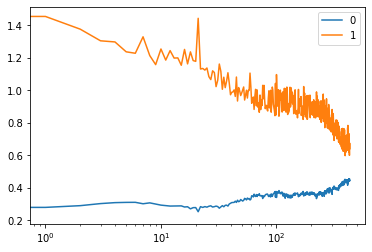

In [39]:
pd.DataFrame(np.array(epoch0_loss)).plot(logx=True)

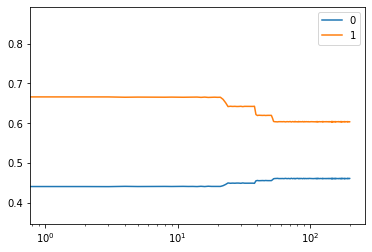

In [40]:
pd.DataFrame(np.array(l_loss)).plot(logx=True)

In [41]:
with gz.open('OUTPUT/loss_c1.pkl.gz', 'wb') as f:
    pkl.dump((epoch0_loss, l_loss), f)

In [42]:
gene_encoded10 = np.array(merged_model.gene_enc(TR_X2_GENE))

In [43]:
with gz.open('OUTPUT/gene_c1_enc.pkl.gz', 'wb') as f:
    pkl.dump(gene_encoded10, f)

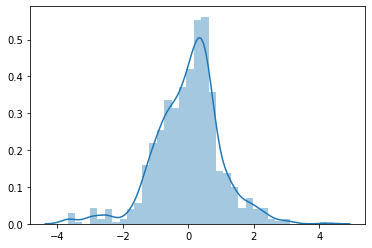

In [44]:
sns.distplot(gene_encoded10.flatten())

In [45]:
total_len = len(TR_X1_SEQ)
L_pred = list()

for x_id in range(0, total_len, 1000):
    TR_1 = TR_X1_SEQ[x_id:x_id+1000]

    pred = merged_model(TR_1, TR_X2_GENE)
    NP_pred = np.array(pred, dtype=np.float16)
    
    L_pred.append(NP_pred)

NP_imputed = np.concatenate(L_pred)
del L_pred
gc.collect()

3522

In [46]:
NP_imputed.shape

(882970, 102, 1)

In [47]:
NP_Met = NP_imputed[:,:,0]
pd.DataFrame(NP_Met).to_csv('OUTPUT/pred_c1_score_met.tsv', sep='\t', header=None, index=None)

In [48]:
Y_Met = TR_Y_PEAK[:,:,1]
pd.DataFrame(Y_Met).to_csv('OUTPUT/peak_c1_met.tsv', sep='\t', header=None, index=None)

In [49]:
Error(Error)

NameError: name 'Error' is not defined